# Installing Required Dependencies

In [1]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
!pip uninstall -y pyarrow
!pip install pyarrow==14.0.1

!pip uninstall -y requests
!pip install requests==2.31.0

Found existing installation: pyarrow 17.0.0
Uninstalling pyarrow-17.0.0:
  Successfully uninstalled pyarrow-17.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 38.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.20.0 requires pyarrow>=15.0.0, but you have pyarrow 14.0.1 which is incompatible.
Found existing installation: requests 2.32.3
Uninstalling requests-2.32.3:
  Successfully uninstalled requests-2.32.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.20.0 requires pyarrow>=15.0.0, but you have pyarrow 14.0.1 which is incompatible.
datasets 2.20.0 requires requests>=2.32.2, but you have requests 2.31.

In [2]:
! pip uninstall -q transformers -y

In [1]:
! pip install -q transformers==4.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 28.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from datasets import load_dataset
from sklearn.model_selection import train_test_split

import re
import string

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


from transformers import DistilBertTokenizer, TFDistilBertModel

from tensorflow.keras.utils import plot_model

# Models Hyperparameters

In [8]:
# output directory name:
output_dir_lstm = 'model_output/biLSTM'
output_dir_cnn = 'model_output/CNN'

# training:
epochs = 5
batch_size = 32


max_seq_length = 200

# LSTM layer architecture:
n_lstm = 100
drop_lstm = 0.2


# CNN layers
n_conv_1, k_conv_1 = 128, 2
n_conv_2, k_conv_2 = 128, 3
n_conv_3, k_conv_3 = 128, 4
n_dense = 128
dropout = 0.2

# Dataset Preprocessing

In [3]:
dataset = load_dataset("imdb")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset['train'])
df['label'] = df['label'].astype(int)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Cleansing

In [4]:
punc = list(string.punctuation)

def preprocess_text(sent):
    # Remove HTML tags
    sent = re.sub(r'<.*?>', '', sent)
    # Remove non-alphabet characters
    sent = re.sub(r'[^A-Za-z]', ' ', sent)
    # Lowercase & remove punctuations
    return ' '.join([word.lower() for word in sent.split() if word.lower() not in punc])

df['text'] = df['text'].apply(preprocess_text)

## Train Val Test Split (70, 10, 20)

In [5]:
# Perform stratified split
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# First split: train + validation and test
train_val_df, test_df = train_test_split(df, test_size=test_ratio, stratify=df['label'], random_state=42)

# Second split: train and validation
train_df, val_df = train_test_split(train_val_df, test_size=val_ratio / (train_ratio + val_ratio), stratify=train_val_df['label'], random_state=42)

In [6]:
print("Training size: ", len(train_df))
print("Validation size: ", len(val_df))
print("Testing size: ", len(test_df))

Training size:  17499
Validation size:  2501
Testing size:  5000


In [7]:
train_df['label'].value_counts()

label
1    8750
0    8749
Name: count, dtype: int64

## Text Tokenization

In [9]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the text data
def tokenize_data(data):
    return tokenizer(
        data['text'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_seq_length,
        return_tensors="tf"
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
train_encodings

{'input_ids': <tf.Tensor: shape=(17499, 200), dtype=int32, numpy=
array([[  101,  1045,  5993, ...,  2467,  4929,   102],
       [  101,  2017,  2113, ...,  3210,  2066,   102],
       [  101,  1045,  1040, ...,  1037,  2450,   102],
       ...,
       [  101,  2026,  2082, ...,  2019, 12476,   102],
       [  101,  2009,  1055, ...,     0,     0,     0],
       [  101,  1042, 23616, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(17499, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [11]:
train_labels = tf.convert_to_tensor(train_df['label'].values)
val_labels = tf.convert_to_tensor(val_df['label'].values)
test_labels = tf.convert_to_tensor(test_df['label'].values)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(10000).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(batch_size)

# BERT Embeddings

In [13]:
# Load DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Disable training for DistilBert model
distilbert_model.trainable = False

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# LSTM-BERT

In [ ]:
# Define the Bi-LSTM model with Dropout
class BiLSTMWithDistilBERT(tf.keras.Model):
    def __init__(self, distilbert_model, lstm_units, dropout_rate):
        super(BiLSTMWithDistilBERT, self).__init__()
        self.distilbert = distilbert_model
        self.bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        distilbert_output = self.distilbert(inputs).last_hidden_state
        lstm_output = self.bilstm(distilbert_output)
        dropout_output = self.dropout(lstm_output)
        flattened_output = tf.keras.layers.Flatten()(dropout_output)
        output = self.dense(flattened_output)
        return output

In [ ]:
lstm_model = BiLSTMWithDistilBERT(distilbert_model, lstm_units=n_lstm, dropout_rate=drop_lstm)

# Compile the model
lstm_model.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
lstm_model.summary()

Model: "bi_lstm_with_distil_bert"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_modelcheckpoint = ModelCheckpoint(filepath=output_dir_lstm+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir_lstm):
    os.makedirs(output_dir_lstm)

# LSTM Training

In [ ]:
# Train the model
lstm_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[lstm_modelcheckpoint])

Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 106s 174ms/step - accuracy: 0.7884 - loss: 0.4804 - val_accuracy: 0.8565 - val_loss: 0.3323
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 94s 171ms/step - accuracy: 0.8780 - loss: 0.2909 - val_accuracy: 0.8645 - val_loss: 0.3227
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 94s 172ms/step - accuracy: 0.9185 - loss: 0.2093 - val_accuracy: 0.8537 - val_loss: 0.3642
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 94s 172ms/step - accuracy: 0.9716 - loss: 0.0899 - val_accuracy: 0.8445 - val_loss: 0.4716
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 94s 172ms/step - accuracy: 0.9927 - loss: 0.0315 - val_accuracy: 0.8449 - val_loss: 0.5660


In [ ]:
lstm_model.load_weights(output_dir_lstm+"/weights.02.keras")

# LSTM Evaluation

In [ ]:
test_loss, test_accuracy = lstm_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predict probabilities
y_hat = lstm_model.predict(test_dataset)
y_hat = y_hat.flatten()
y_valid = test_labels.numpy()

157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.8754 - loss: 0.2970
Test Loss: 0.3059428334236145, Test Accuracy: 0.8705999851226807
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step


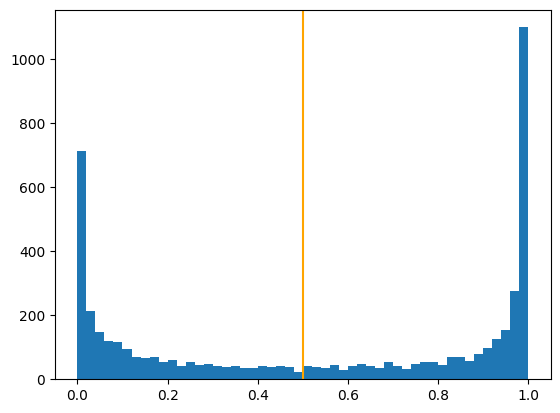

In [ ]:
# Plot histogram of predicted probabilities
plt.hist(y_hat, bins=50)
_ = plt.axvline(x=0.5, color='orange')
plt.show()

In [ ]:
# Print AUC score
auc_score = roc_auc_score(y_valid, y_hat)
print("AUC Score: {:0.2f}".format(auc_score * 100.0))

AUC Score: 94.75


In [ ]:
# Convert probabilities to binary predictions
y_pred = np.where(y_hat > 0.5, 1, 0)

# Print classification report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.83      0.86      2500
           1       0.84      0.91      0.88      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



# CNN-BERT

In [14]:
# Define CNN model with DistilBERT embeddings
input_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name='attention_mask')

distilbert_output = distilbert_model([input_ids, attention_mask]).last_hidden_state


conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(distilbert_output)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(distilbert_output)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(distilbert_output)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

# Concatenate the activations from the three streams
concat = concatenate([maxp_1, maxp_2, maxp_3])

# Dense hidden layers
dense_layer = Dense(n_dense, activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)
dense_2 = Dense(int(n_dense/4), activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(dropout, name='drop_dense_2')(dense_2)

# Sigmoid output layer
predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

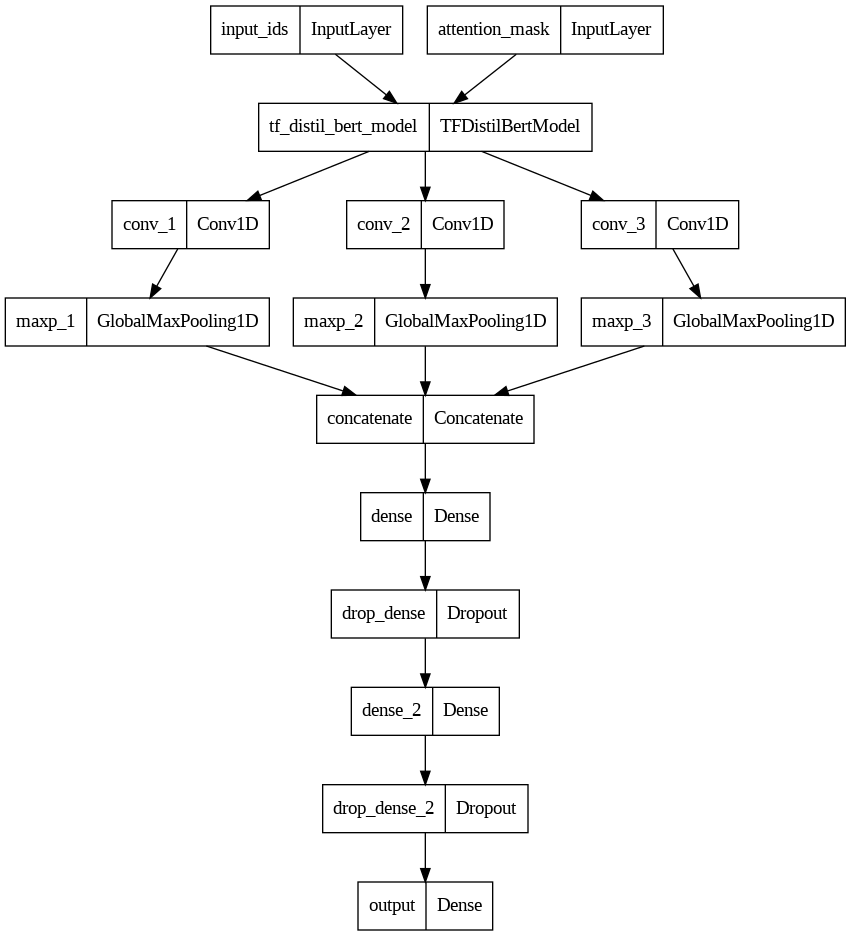

In [19]:
# Create model
cnn_model = Model(inputs=[input_ids, attention_mask], outputs=predictions)

# Visualize the model architecture
plot_model(cnn_model, to_file='cnn_model_plot.png', show_layer_names=True)


In [20]:
# Compile the model
cnn_model.compile(optimizer='nadam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [18]:
cnn_modelcheckpoint = ModelCheckpoint(filepath=output_dir_cnn+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir_cnn):
    os.makedirs(output_dir_cnn)

# CNN Training

In [22]:
# Train!
history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[cnn_modelcheckpoint])


Epoch 1/5
547/547 [==============================] - 95s 152ms/step - loss: 0.3982 - accuracy: 0.8192 - val_loss: 0.3193 - val_accuracy: 0.8701
Epoch 2/5
547/547 [==============================] - 81s 148ms/step - loss: 0.2982 - accuracy: 0.8764 - val_loss: 0.2985 - val_accuracy: 0.8749
Epoch 3/5
547/547 [==============================] - 81s 148ms/step - loss: 0.2600 - accuracy: 0.8948 - val_loss: 0.2908 - val_accuracy: 0.8796
Epoch 4/5
547/547 [==============================] - 81s 148ms/step - loss: 0.2191 - accuracy: 0.9156 - val_loss: 0.3516 - val_accuracy: 0.8697
Epoch 5/5
547/547 [==============================] - 81s 148ms/step - loss: 0.1754 - accuracy: 0.9349 - val_loss: 0.3178 - val_accuracy: 0.8808


In [23]:
cnn_model.load_weights(output_dir_cnn+"/weights.03.keras")

# CNN Evaluation

In [24]:
test_loss, test_accuracy = cnn_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predict probabilities
y_hat = cnn_model.predict(test_dataset)
y_hat = y_hat.flatten()
y_valid = test_labels.numpy()

157/157 [==============================] - 18s 116ms/step - loss: 0.2738 - accuracy: 0.8844
Test Loss: 0.2738363444805145, Test Accuracy: 0.8844000101089478
157/157 [==============================] - 20s 115ms/step


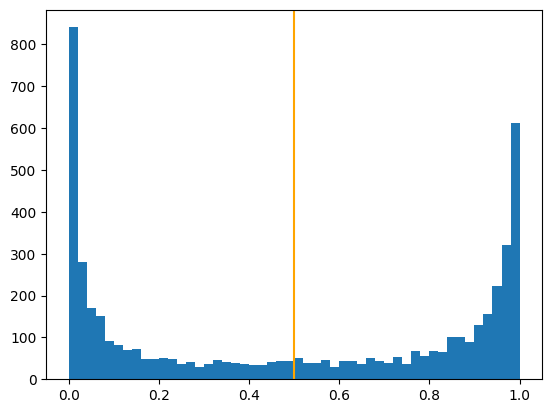

In [25]:
# Plot histogram of predicted probabilities
plt.hist(y_hat, bins=50)
_ = plt.axvline(x=0.5, color='orange')
plt.show()

In [26]:
# Print AUC score
auc_score = roc_auc_score(y_valid, y_hat)
print("AUC Score: {:0.2f}".format(auc_score * 100.0))

AUC Score: 95.50


In [27]:
# Convert probabilities to binary predictions
y_pred = np.where(y_hat > 0.5, 1, 0)

# Print classification report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2500
           1       0.88      0.89      0.89      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

